## 0. Setup: Install Libraries

In [13]:
# Installs necessary packages
!pip install -q openai==1.107.0 python-dotenv==1.1.1

## 1. Setup: Define Constants, Load API Key & Choose Workflow

### Imports required libraries

In [14]:
# --- Core Imports ---
import os
import openai
import base64
import json
import re
import io
import time
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown, Code, HTML
from google.colab import files
from google.colab import userdata
print("Libraries imported.")

Libraries imported.


### Defines pricing constants for OpenAI models (verify these periodically).

In [15]:
# --- Pricing Constants (Approx. Sep 2025 - **VERIFY on OpenAI pricing page!**) ---
# Stores the cost per million tokens for input and output of various text models.
PRICES_TEXT_USD_PER_MILLION_TOKENS = { # USD per 1M tokens for text models
    "gpt-5": {"input": 1.25, "output": 10.00},
    "gpt-5-mini": {"input": 0.25, "output": 2.00},
}
# Cost per million tokens for the text prompt sent to image generation/edit models.
PRICE_IMAGE_PROMPT_INPUT_USD_PER_MILLION_TOKENS = 5.00
# Cost per million tokens for processing input image data (edit endpoint)
PRICE_IMAGE_INPUT_USD_PER_MILLION_TOKENS = 10.00
# Cost per million tokens for generating output image pixels.
PRICE_IMAGE_OUTPUT_USD_PER_MILLION_TOKENS = 40.00
print("Pricing constants defined.")

Pricing constants defined.


### Defines helper functions for cost calculation and API parameter conversion

In [16]:
# --- Helper Functions ---

def get_api_image_size_parameter(display_size_selection):
    """
    Converts a user-friendly display size string (e.g., '1024x1024 (Square)')
    into the format required by the OpenAI API ('1024x1024'). Handles 'auto'.

    Args:
        display_size_selection (str): The size string selected by the user.

    Returns:
        str or None: The API-compatible size string ('auto', '1024x1024', etc.)
                     or None if the format is invalid.
    """
    if display_size_selection == "auto": return "auto"
    match = re.match(r"^(\d+x\d+)", display_size_selection) # Extracts the WxH part
    return match.group(1) if match else None

def calculate_cost_from_tokens(token_count, price_per_million_tokens):
    """
    Calculates the cost based on the number of tokens and the price per million tokens.

    Args:
        token_count (int): The number of tokens used.
        price_per_million_tokens (float): The cost in USD per 1,000,000 tokens.

    Returns:
        float: The calculated cost in USD.
    """
    if token_count is None or token_count < 0: token_count = 0 # Handle potential None values
    return (token_count / 1_000_000) * price_per_million_tokens

def guess_mime_type_from_filename(filename):
    """
    Guesses the MIME type of a file based on its extension. Used for API uploads.

    Args:
        filename (str): The name of the file.

    Returns:
        str: The guessed MIME type (e.g., 'image/png', 'image/jpeg') or a default.
    """
    ext = os.path.splitext(filename)[1].lower()
    if ext == '.png': return 'image/png'
    if ext in ['.jpg', '.jpeg']: return 'image/jpeg'
    if ext == '.webp': return 'image/webp'
    return 'application/octet-stream' # Default binary type if extension is unknown

print("Helper functions defined.")

Helper functions defined.


### Loads the OpenAI API key from Colab Secrets, .env file, or manual input

In [17]:
# --- Load API Key ---
print("\nAttempting to load OpenAI API key...")
# Holds the API key value.
openai_api_key = None
# Describes where the API key was loaded from (e.g., Colab Secrets, .env).
api_key_source_description = "Unknown"

# Priority 1: Colab Secrets (Recommended for security)
try:
    # Ensure your secret is named 'OPENAI_API_KEY' in Google Colab Secrets Manager.
    openai_api_key = userdata.get('OPENAI_API_KEY')
    if openai_api_key: api_key_source_description = "Colab Secrets"
except Exception:
    pass # Ignore if not in Colab or secrets not available

# Priority 2: Environment Variable (.env file in the same directory)
if not openai_api_key:
    load_dotenv() # Loads variables from a .env file if present
    openai_api_key = os.getenv('OPENAI_API_KEY')
    if openai_api_key: api_key_source_description = "Environment Variable (.env)"

# Priority 3: Manual Input (Least secure, use only if necessary)
if not openai_api_key:
    print("🔐 API Key not found automatically. Please enter your OpenAI API Key manually:")
    openai_api_key = input()
    if openai_api_key:
        api_key_source_description = "Manual Input"
    else:
        # If no key is provided after all attempts, raise an error.
        raise ValueError("🚨 FATAL: No OpenAI API Key provided. Cannot proceed.")

# Display confirmation of successful key loading.
print(f"✅ API Key loaded successfully from: {api_key_source_description} (starts with: {openai_api_key[:4]}...).")



Attempting to load OpenAI API key...
✅ API Key loaded successfully from: Colab Secrets (starts with: sk-p...).


### Initializes the OpenAI API client.

In [18]:
# --- Initialize OpenAI Client ---
try:
    # The main object used to interact with the OpenAI API.
    openai_client = openai.OpenAI(api_key=openai_api_key)
    print("✅ OpenAI client initialized successfully.")
except Exception as e:
    print(f"🚨 FATAL Error: Could not initialize OpenAI client: {e}")
    raise # Stop execution if the client cannot be initialized

✅ OpenAI client initialized successfully.


### Initializes global variables for tracking costs and shared state between workflows

In [19]:
# --- Global Variables for State & Cost Tracking ---
# These variables store costs calculated in different workflow cells.
# They are initialized here and updated within the respective workflow cells.

# Stores the cost incurred for LLM-based prompt generation in the Text-to-Image workflow.
cost_prompt_engineering = 0.0
# Stores the cost for the text prompt input to the image generation model in the Text-to-Image workflow.
cost_t2i_gen_prompt_input = 0.0
# Stores the cost for the generated image output in the Text-to-Image workflow.
cost_t2i_gen_output = 0.0

# Stores the cost for the text prompt input to the image edit/reference model.
cost_edit_prompt_input = 0.0
# Stores the cost for the generated image output in the Image Input workflow.
cost_edit_output = 0.0
# Stores the cost for processing input images (if reported by API) in the Image Input workflow.
cost_edit_image_input = 0.0

# Stores the final image prompt generated by the LLM in the Text-to-Image workflow. Used as input for image generation.
generated_image_prompt_t2i = None
# Stores uploaded file data (filename, content) for the Image Input workflow. Structure depends on the edit mode.
image_input_uploaded_files = {}
print("Global variables for cost tracking and state initialized.")

Global variables for cost tracking and state initialized.


### Provides a dropdown to select the desired image generation workflow

In [26]:
# --- Workflow Selection ---
# This dropdown allows the user to choose the main operation mode for the notebook.
# The selected value determines which subsequent code cells should be run.
print("\n--- Choose Your Workflow ---")
SELECTED_WORKFLOW = "Image Input (Edit/Reference)" # @param ["Guided Text-to-Image (My Idea)", "Feeling Lucky (AI Creates Concept)", "Image Input (Edit/Reference)"] {allow-input: false}
print(f"➡️ You selected workflow: \"{SELECTED_WORKFLOW}\"")
print("-" * 40)

# --- Guidance for Next Steps ---
# Provides instructions based on the selected workflow.
if SELECTED_WORKFLOW in ["Guided Text-to-Image (My Idea)", "Feeling Lucky (AI Creates Concept)"]:
    print("‼️ NEXT STEP: >>> Run the 'Workflow: Text-to-Image Generation' cell below <<<")
    print("             >>> Then SKIP the 'Workflow: Image Input' cell. <<<")
elif SELECTED_WORKFLOW == "Image Input (Edit/Reference)":
    print("‼️ NEXT STEP: >>> SKIP the 'Workflow: Text-to-Image Generation' cell. <<<")
    print("             >>> Then Run the 'Workflow: Image Input' cell below <<<")
else:
    # Fallback for unexpected workflow values.
    print("🚨 Unknown workflow selected. Please re-run this setup cell and choose a valid option.")
print("-" * 40)
print("✅ Setup and Workflow Choice Complete. Follow the 'NEXT STEP' instructions above.")


--- Choose Your Workflow ---
➡️ You selected workflow: "Image Input (Edit/Reference)"
----------------------------------------
‼️ NEXT STEP: >>> SKIP the 'Workflow: Text-to-Image Generation' cell. <<<
             >>> Then Run the 'Workflow: Image Input' cell below <<<
----------------------------------------
✅ Setup and Workflow Choice Complete. Follow the 'NEXT STEP' instructions above.


## 2. Workflow: Text-to-Image Generation (Guided or Lucky)

### Stage 1: Configures and calls a text LLM (like GPT-5) to generate a detailed image prompt based on user inputs (Guided) or completely autonomously (Feeling Lucky)

In [27]:
# --- Initial Workflow Check ---
# Ensures this cell is run only when the appropriate workflow is selected.
if SELECTED_WORKFLOW not in ["Guided Text-to-Image (My Idea)", "Feeling Lucky (AI Creates Concept)"]:
    print(f"⚠️ Skipping Text-to-Image Workflow cell: Your selected workflow is '{SELECTED_WORKFLOW}'.")

else:
    print(f"🚀 Starting Text-to-Image Workflow: {SELECTED_WORKFLOW}")
    # Reset costs and state specific to this workflow execution
    cost_prompt_engineering = 0.0
    cost_t2i_gen_prompt_input = 0.0
    cost_t2i_gen_output = 0.0
    generated_image_prompt_t2i = None # Clear any prompt from previous runs

    # --- Stage 1: Configure & Generate Detailed Image Prompt ---
    print("\n--- Stage 1: Configure & Generate Detailed Image Prompt ---")

    # [Text-to-Image] The core subject or concept for the image prompt (Required in Guided mode).
    T2I_BASIC_IDEA_INPUT = "A surreal steampunk underwater city with coral skyscrapers, floating gears, mechanical  sea turtles, and glowing submersibles." #@param {type:"string", description:"Main subject/concept for the image. Required in Guided mode."}

    # [Text-to-Image] Optional artistic style, mood, or specific artist influence.
    T2I_STYLE_GUIDANCE_INPUT = "Inspired by Blade Runner, cinematic lighting" #@param {type:"string", description:"Optional style keywords (e.g., oil painting, anime, cinematic)."}

    # [Text-to-Image] Optional specific elements, objects, or features to include/exclude. Use 'transparent background' for transparency.
    T2I_DETAIL_INSTRUCTIONS_INPUT = "A whimsical, hyper-detailed underwater metropolis rises from the ocean floor, its glowing coral skyscrapers carved into fractal spires and bioluminescent algae weaving organic neon filigree. Towering jellyfish lanterns drift lazily overhead, their translucent bells pulsing in soft aquamarine, lavender, and rose hues, casting intricate lace-like light patterns on the rippling streets below. Merfolk in ornate, scale-latticed armor glide past, their finned cloaks trailing iridescent ribbons, exchanging baskets of glowing plankton at a market stall built from giant nautilus shells. In the midground, a curious merchild in pearlescent robes coaxes a playful octopus—its eight arms glowing faintly blue—to dance through rings of floating bubbles. Beyond them, a majestic sea dragon, its body covered in teal and emerald scales that refract light like stained glass, coils around a coral tower studded with pearl-like windows, gazing toward the sunlit surface where shafts of golden light pierce the twilight gloom. Schools of tiny iridescent fish weave through kelp-like neon vines and around carved shell archways, creating living mosaics in the water’s soft currents. Shafts of volumetric light filter through drifting silt, revealing glittering golden motes that float like distant stars. The entire scene is composed with a slight low-angle perspective—emphasizing the grandeur of the coral skyline—rendered in ultra-realistic detail with crisp textures on coral polyps, razor-sharp fin edges, and the delicate, vein-like patterns on jellyfish tentacles. Subsurface caustics dance across every surface, uniting the palette of deep blues, verdant greens, and flecks of molten gold into an otherworldly symphony of light and color." #@param {type:"string", description:"Optional details (e.g., include red apples, exclude text, transparent background)."}

    # [Text-to-Image] Optional guidance on camera angle, shot type, or lighting direction.
    T2I_COMPOSITION_LIGHTING_INPUT = "Low angle shot looking up, focus on atmospheric perspective" #@param {type:"string", description:"Optional composition/lighting (e.g., wide angle, dramatic lighting)."}

    # [Text-to-Image] Selects the text model used for generating the detailed image prompt.
    T2I_PROMPT_MODEL_SELECTOR = "gpt-5" #@param ["gpt-5", "gpt-5-mini"] {description:"Choose the LLM for prompt generation. Affects cost and quality."}

    # [Text-to-Image] Selects the text model used for generating the detailed image prompt.
    T2I_REASONING_EFFORT = "minimal" #@param ["minimal", "low","medium","high"] {description:"Choose the LLM for prompt generation. Affects cost and quality."}


    # [Text-to-Image] Sets the maximum length (in tokens) for the generated image prompt.
    T2I_PROMPT_MAX_TOKENS_INPUT = 400 #@param {type:"integer", min:50, description:"Maximum token limit for the generated image prompt."}

    if SELECTED_WORKFLOW == "Feeling Lucky (AI Creates Concept)":
        # Clear user inputs for clarity, though they won't be used
        user_basic_idea = ""
        user_style_guidance = ""
        user_detail_instructions = ""
        user_composition_lighting = ""
    else: # Guided Mode
        print("📝 Guided Mode: Using your inputs to generate the image prompt.")
        user_basic_idea = T2I_BASIC_IDEA_INPUT
        user_style_guidance = T2I_STYLE_GUIDANCE_INPUT
        user_detail_instructions = T2I_DETAIL_INSTRUCTIONS_INPUT
        user_composition_lighting = T2I_COMPOSITION_LIGHTING_INPUT
        if not user_basic_idea.strip():
          raise ValueError("🚨 Input Error: 'Basic Idea' cannot be empty in 'Guided Text-to-Image' mode!")

    # --- Construct Prompts for the Text LLM ---
    # System prompt defining the role and behavior of the prompt generation LLM.
    prompt_generation_system_message = f"""
You are an expert prompt engineer specializing in creating prompts for AI image generation models like gpt-image-1.
Your goal is to generate a single, detailed, and visually rich image prompt, adhering to a maximum token limit of approximately {T2I_PROMPT_MAX_TOKENS_INPUT}.
Focus on incorporating elements like: subject, setting, atmosphere, artistic style, specific details, composition, and lighting.

**Behavior Rules:**
- If the user chose 'Feeling Lucky', completely ignore any provided inputs ('Basic Idea', 'Style', etc.) and invent a creative, novel concept and the corresponding detailed prompt yourself.
- If the user chose 'Guided', start with the 'Basic Idea' provided. Integrate any 'Style', 'Details', and 'Composition/Lighting' inputs given by the user. If any of these optional fields are empty, YOU MUST CREATIVELY INVENT appropriate content for those aspects, ensuring they complement the 'Basic Idea'.
- If the user's input for 'Details' includes the phrase 'transparent background', ensure the final generated prompt explicitly contains the exact phrase 'transparent background'.
- **Output Format:** Respond ONLY with the final image prompt text. Do not include any introductory phrases, explanations, apologies, or concluding remarks. Just the prompt itself.
"""
    # User prompt providing the specific inputs and mode for the LLM.
    if SELECTED_WORKFLOW == "Feeling Lucky (AI Creates Concept)":
        prompt_generation_user_message = "Mode: Feeling Lucky. Generate an imaginative image prompt."
    else: # Guided Mode
        prompt_generation_user_message = f"""
        Mode: Guided. Generate an image prompt based on the following inputs:
        Basic Idea (Required): {user_basic_idea}
        Optional Style Guidance: {user_style_guidance if user_style_guidance.strip() else '(Invent appropriate style if blank)'}
        Optional Detail Instructions: {user_detail_instructions if user_detail_instructions.strip() else '(Invent appropriate details if blank)'}
        Optional Composition/Lighting: {user_composition_lighting if user_composition_lighting.strip() else '(Invent appropriate composition/lighting if blank)'}
        """
        # Special handling for transparency request
        if "transparent background" in user_detail_instructions.lower():
             prompt_generation_user_message += "\nIMPORTANT NOTE: The user requested a 'transparent background'. Ensure this exact phrase appears in your final output prompt."

    # --- Call Text LLM API for Prompt Generation ---
    print(f"\n🤖 Asking {T2I_PROMPT_MODEL_SELECTOR} to generate the image prompt...")
    try:
        start_time_prompt_gen = time.time()
        # Response object from the Response API call.
        llm_prompt_response = openai_client.responses.create(
            model=T2I_PROMPT_MODEL_SELECTOR,
            instructions=prompt_generation_system_message,
            input=prompt_generation_user_message,
            reasoning={'effort':T2I_REASONING_EFFORT}
        )
        end_time_prompt_gen = time.time()
        # Extract the generated prompt text from the response.
        generated_image_prompt_t2i = llm_prompt_response.output[1].content[0].text.strip()

        print(f"\n✅ Prompt generated successfully in {end_time_prompt_gen - start_time_prompt_gen:.2f} seconds.")
        display(Markdown("**Generated Image Prompt (from LLM):**"))
        display(Markdown(f"> {generated_image_prompt_t2i}")) # Display the generated prompt

        # --- Calculate Cost for Prompt Generation ---
        # Extract token usage details from the API response.
        prompt_gen_prompt_tokens = llm_prompt_response.usage.input_tokens

        # Output tokens with reasoning tokens (GPT-5 / GPT-5-mini)
        prompt_gen_completion_tokens = llm_prompt_response.usage.output_tokens
        # Calculate costs using the helper function and price constants.
        prompt_gen_input_cost = calculate_cost_from_tokens(
            prompt_gen_prompt_tokens,
            PRICES_TEXT_USD_PER_MILLION_TOKENS[T2I_PROMPT_MODEL_SELECTOR]["input"]
        )
        prompt_gen_output_cost = calculate_cost_from_tokens(
            prompt_gen_completion_tokens,
            PRICES_TEXT_USD_PER_MILLION_TOKENS[T2I_PROMPT_MODEL_SELECTOR]["output"]
        )
        # Store the total cost for this stage in the global variable.
        cost_prompt_engineering = prompt_gen_input_cost + prompt_gen_output_cost
        print(f"\n💰 Cost for Prompt Generation Stage:")
        print(f"   Model Used: {T2I_PROMPT_MODEL_SELECTOR}")
        print(f"   Input Tokens: {prompt_gen_prompt_tokens} (${prompt_gen_input_cost:.6f})")
        print(f"   Output Tokens: {prompt_gen_completion_tokens} (${prompt_gen_output_cost:.6f})")
        print(f"   >> Stage 1 Total: ${cost_prompt_engineering:.6f}")

    except openai.APIError as api_err:
         # Handle specific OpenAI API errors.
         print(f"🚨 OpenAI API Error during Prompt Generation: Status Code {api_err.status_code} - {api_err.message}")
         generated_image_prompt_t2i = None # Ensure prompt is None if generation failed
    except Exception as e:
        # Handle other potential errors during prompt generation.
        print(f"🚨 An unexpected error occurred during prompt generation: {e}")
        generated_image_prompt_t2i = None # Ensure prompt is None

⚠️ Skipping Text-to-Image Workflow cell: Your selected workflow is 'Image Input (Edit/Reference)'.


### Stage 2: Configures and calls the image generation model (gpt-image-1) using the prompt from Stage 1. Displays the generated image(s) and calculates costs.

In [28]:
# --- Stage 2: Configure & Generate Image from Text Prompt ---
# This stage only runs if the prompt generation in Stage 1 was successful.
if SELECTED_WORKFLOW in ["Guided Text-to-Image (My Idea)", "Feeling Lucky (AI Creates Concept)"] and generated_image_prompt_t2i:
    print("\n--- Stage 2: Configure & Generate Image from Text Prompt ---")

    # [Text-to-Image] Desired dimensions for the generated image(s). 'auto' defaults to 1024x1024.
    T2I_IMAGE_SIZE_SELECTOR = "1536x1024 (Landscape)" #@param ["auto", "1024x1024 (Square)", "1024x1536 (Portrait)", "1536x1024 (Landscape)"] {description:"Select the output image dimensions."}

    # [Text-to-Image] Quality level for the generated image(s). Affects detail and cost. 'auto' defaults to 'medium'.
    T2I_IMAGE_QUALITY_SELECTOR = "medium" #@param ["auto", "low", "medium", "high"] {description:"Choose image quality. Higher quality costs more."}

    # [Text-to-Image] Number of images to generate from the same prompt in one API call.
    T2I_NUM_IMAGES_SLIDER = 1 #@param {type:"slider", min:1, max:4, step:1, description:"How many variations to generate."}

    # Convert the user-friendly size selection to the API format.
    api_image_size_param = get_api_image_size_parameter(T2I_IMAGE_SIZE_SELECTOR)
    if not api_image_size_param:
        raise ValueError("🚨 Configuration Error: Invalid Image Size selected. Please re-run the cell with a valid size.")

    # Get the quality setting for the API call.
    api_image_quality_param = T2I_IMAGE_QUALITY_SELECTOR

    print(f"\n🖼️ Requesting {T2I_NUM_IMAGES_SLIDER} image(s) from gpt-image-1...")
    print(f"   Using Generated Prompt: \"{generated_image_prompt_t2i[:100]}...\"") # Show preview
    print(f"   Requested Size: {api_image_size_param} (Selected: '{T2I_IMAGE_SIZE_SELECTOR}')")
    print(f"   Requested Quality: {api_image_quality_param}")

    # --- Call Image Generation API ---
    try:
        start_time_img_gen = time.time()
        # Response object from the image generation API call.
        text_to_image_api_response = openai_client.images.generate(
            model="gpt-image-1", # Currently the primary model for this task
            prompt=generated_image_prompt_t2i,
            size=api_image_size_param,
            quality=api_image_quality_param,
            n=T2I_NUM_IMAGES_SLIDER,
        )
        end_time_img_gen = time.time()
        print(f"\n✅ Image(s) generated successfully in {end_time_img_gen - start_time_img_gen:.2f} seconds.")

        # --- Process and Display Generated Images ---
        # Access the list of generated image data objects.
        generated_image_data_list = text_to_image_api_response.data
        for i, image_data_object in enumerate(generated_image_data_list):
            print(f"\n--- Generated Image {i+1} of {T2I_NUM_IMAGES_SLIDER} ---")
            try:
                # Check if b64_json data is present.
                if image_data_object.b64_json:
                  # Decode the Base64 string into image bytes.
                  image_bytes_content = base64.b64decode(image_data_object.b64_json)
                  # Display the image directly in the notebook.
                  display(Image(data=image_bytes_content))

                  # --- Create Download Link ---
                  # Re-encode bytes to base64 string for the data URL.
                  b64_for_download = base64.b64encode(image_bytes_content).decode('utf-8')
                  # Create a safe filename prefix from the prompt.
                  safe_prompt_prefix = re.sub(r'[^\w-]', '_', generated_image_prompt_t2i[:30])
                  download_filename = f"t2i_{safe_prompt_prefix}_{i+1}.png"
                  # Display a markdown link for downloading the image.
                  html_link = f'<a download="{download_filename}" href="data:image/png;base64,{b64_for_download}" target="_blank">🖱️ Download Image {i+1} as {download_filename}</a>'
                  display(HTML(html_link))

                else:
                  # Handle cases where b64_json might be missing (e.g., if API defaults changed or error occurred).
                  image_url = image_data_object.url if hasattr(image_data_object, 'url') else 'N/A'
                  print(f"🚨 Image {i+1}: No Base64 data found in response. URL (if available): {image_url}")

            except base64.binascii.Error as decode_err:
                print(f"🚨 Error decoding Base64 data for image {i+1}: {decode_err}")
            except Exception as display_err:
                print(f"🚨 Error processing or displaying image {i+1}: {display_err}")

        # --- Calculate Image Generation Costs ---
        print("\n💰 Cost for Image Generation Stage:")

        # 1. Prompt Input Cost (Reported by API)
        # Convert response to dict for safe access to usage data.
        response_dict = text_to_image_api_response.to_dict()
        # Extract the number of tokens used for the input prompt.
        image_gen_prompt_tokens = response_dict.get("usage", {}).get("input_tokens", 0)
        # Calculate the cost for the text prompt input.
        cost_t2i_gen_prompt_input = calculate_cost_from_tokens(
            image_gen_prompt_tokens,
            PRICE_IMAGE_PROMPT_INPUT_USD_PER_MILLION_TOKENS
        )
        print(f"   Text Prompt Input: {image_gen_prompt_tokens} tokens (${cost_t2i_gen_prompt_input:.6f})")

        # 2. Output Cost

        total_output_tokens = response_dict.get("usage", {}).get("output_tokens", 0)
        cost_t2i_gen_output = calculate_cost_from_tokens(
            total_output_tokens,
            PRICE_IMAGE_OUTPUT_USD_PER_MILLION_TOKENS
        )

        print(f"   Image Output: {total_output_tokens} tokens (${cost_t2i_gen_output:.6f})")
        print(f"   ---------------------")
        # Calculate the total stage cost ( input + output).
        total_stage_2_cost = cost_t2i_gen_prompt_input + cost_t2i_gen_output
        print(f"   >> Stage 2 Total ( Input + Output): ${total_stage_2_cost:.6f}")

    except openai.APIError as api_err:
        print(f"🚨 OpenAI API Error during Image Generation: Status Code {api_err.status_code} - {api_err.message}")
    except Exception as e:
        print(f"🚨 An unexpected error occurred during image generation: {e}")

    # --- Total Workflow Cost Summary (Text-to-Image) ---
    finally:
        # Calculate the grand total cost for this workflow run.
        total_cost_text_to_image_workflow = cost_prompt_engineering + cost_t2i_gen_prompt_input + cost_t2i_gen_output
        print("\n" + "="*40)
        print("📊 TOTAL COST FOR THIS TEXT-TO-IMAGE WORKFLOW RUN (Based on the Token Usage Reported by API)")
        print(f"   Stage 1 (Prompt Engineering): ${cost_prompt_engineering:.6f}")
        print(f"   Stage 2 (Image Gen - Prompt In): ${cost_t2i_gen_prompt_input:.6f}")
        print(f"   Stage 2 (Image Gen - Output):   ${cost_t2i_gen_output:.6f}")
        print(f"   -----------------------------")
        print(f"   GRAND TOTAL: ${total_cost_text_to_image_workflow:.6f}")
        print("="*40)

        # Final message indicating the end of this workflow cell's execution.
        print("\n✅ Cell 'Workflow: Text-to-Image Generation' Execution Finished.")
else:
    # Message if Stage 1 (prompt generation) failed or was skipped.
    if SELECTED_WORKFLOW in ["Guided Text-to-Image (My Idea)", "Feeling Lucky (AI Creates Concept)"] and not generated_image_prompt_t2i:
         print("\n⏩ Skipping Stage 2 (Image Generation) because the image prompt was not successfully generated in Stage 1.")
    elif SELECTED_WORKFLOW not in ["Guided Text-to-Image (My Idea)", "Feeling Lucky (AI Creates Concept)"]:
      print(f"\n Skipping this step, Because selected workflow is {SELECTED_WORKFLOW}")


 Skipping this step, Because selected workflow is Image Input (Edit/Reference)


## 3. Workflow: Image Input (Edit/Reference)

🚀 Starting Image Input Workflow: Edit/Reference

--- Stage 1: Configure Edit/Reference Settings ---
   Mode selected: Generate from Multiple References

--- Stage 2: Upload Required Files ---
➡️ Please upload 1 to 4 reference image files (formats: PNG, JPG/JPEG, WEBP):


Saving Img1.png to Img1 (1).png
Saving Img2.png to Img2 (1).png
Saving Img3.png to Img3 (1).png
   ✅ Uploaded reference image 1: 'Img1 (1).png' (1812482 bytes)
   ✅ Uploaded reference image 2: 'Img2 (1).png' (1671904 bytes)
   ✅ Uploaded reference image 3: 'Img3 (1).png' (1651050 bytes)

--- Stage 3: Prepare API Arguments and Call OpenAI ---
   Prepared reference image 1 ('Img1 (1).png') (MIME: image/png) for API call.
   Prepared reference image 2 ('Img2 (1).png') (MIME: image/png) for API call.
   Prepared reference image 3 ('Img3 (1).png') (MIME: image/png) for API call.
   Attempting to pass 3 reference image(s) as a list of (filename, file, mime_type) tuples to the API's 'image' parameter.

🚀 Calling OpenAI Images API ('edit' endpoint) with 3 item(s) potentially tokenized for input...

✅ Image edit/reference generation successful in 92.80 seconds.

--- Output Image 1 of 1 ---


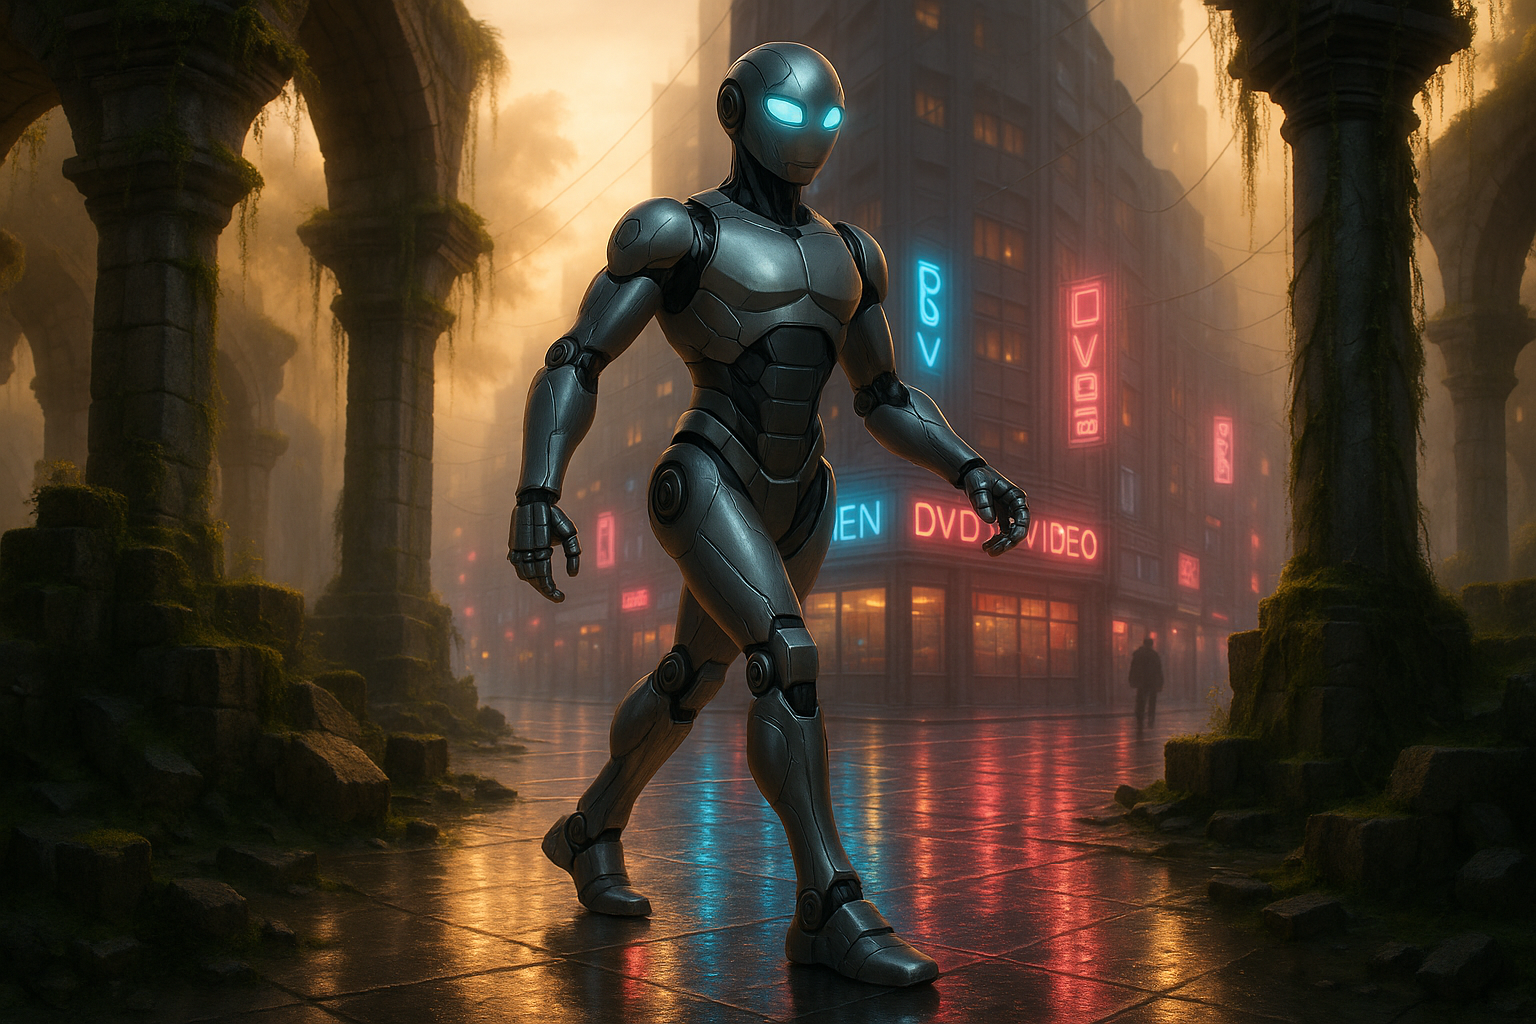


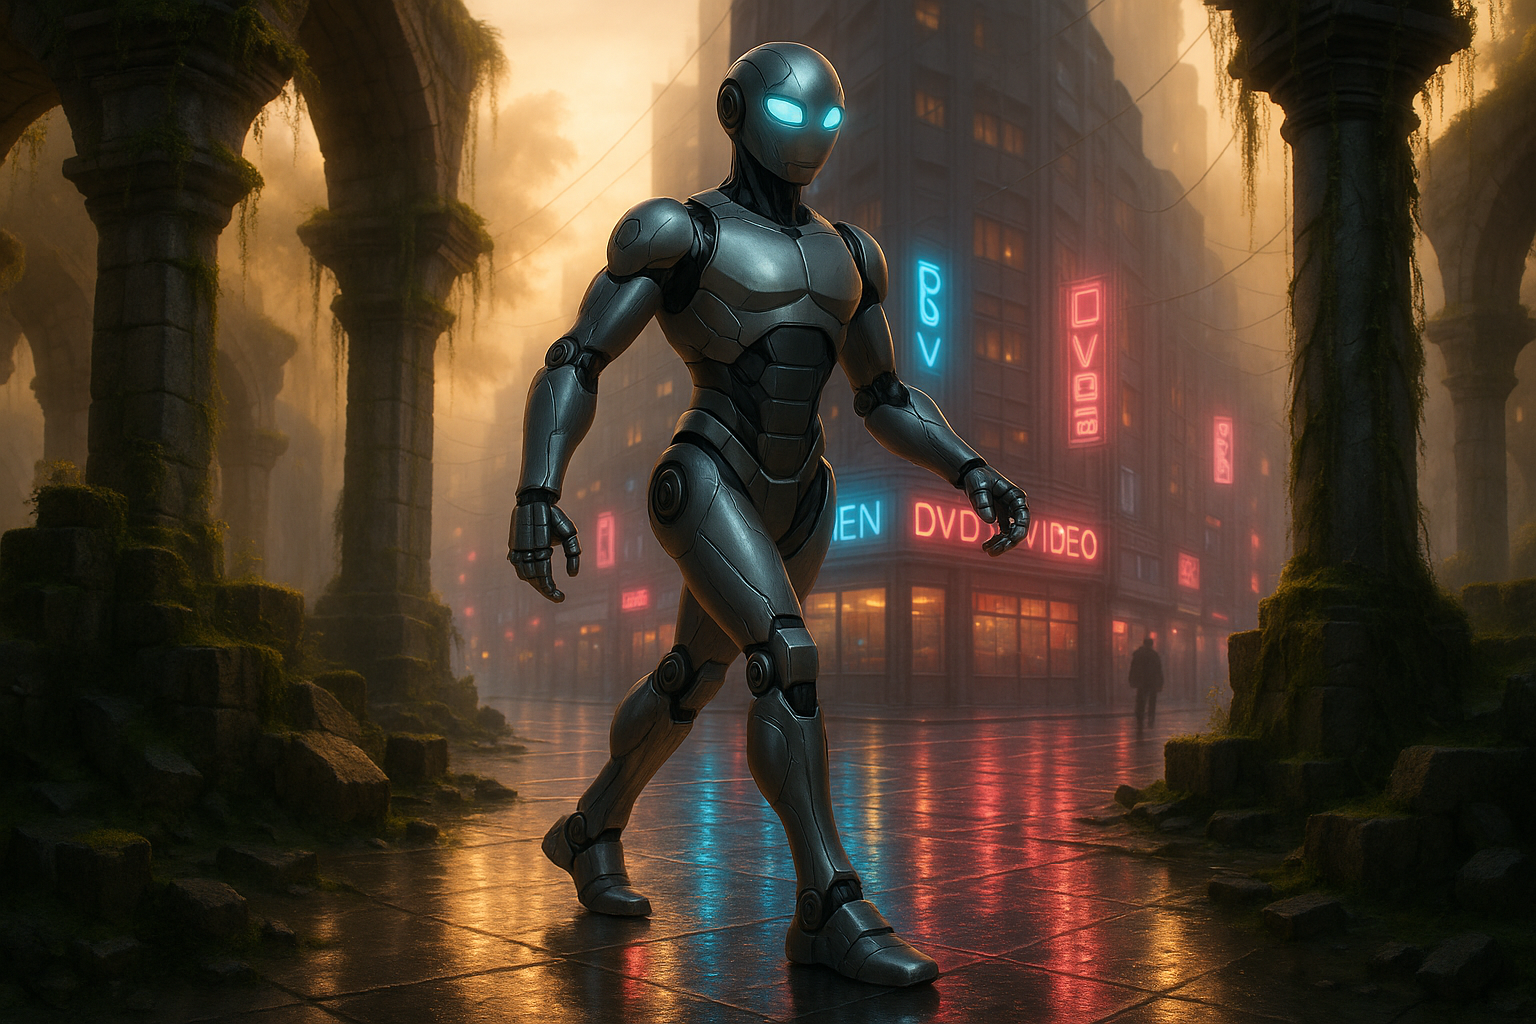


💰 Cost for Image Edit/Reference Generation Stage:
   Text Prompt Input: 128 tokens ($0.000640)
   Image Input: 582 tokens ($0.005820)
   Image Output: 6208 tokens ($0.248320) (As reported by API)
   ---------------------
   >> Stage 3 Total (Calculable Parts): $0.254780

📊 TOTAL CALCULABLE COST FOR THIS IMAGE INPUT WORKFLOW RUN (Based on the Token Usage Reported by API)
   Text Prompt Input: $0.000640
   Image Input Cost:  $0.005820
   Image Output Cost: $0.248320
   -----------------------------
   GRAND TOTAL (Calculable Parts): $0.254780

✅ Cell 'Workflow: Image Input (Edit/Reference)' Execution Finished.


In [29]:
# It first checks if this workflow was selected in the setup cell.
# Stage 1: Configures settings like edit mode, prompt, output size, and mask usage.
# Stage 2: Handles uploading the required image(s) (primary image, optional mask, or reference images).
# Stage 3: Prepares arguments, calls the appropriate OpenAI image API endpoint (edit or variations - though using edit for both here),
#          displays the resulting image(s), and calculates costs.
#          Note: The cost for processing input images is *not* reported by the API and cannot be calculated accurately.

# --- Initial Workflow Check ---
# Ensures this cell is run only when the 'Image Input' workflow is selected.
if 'SELECTED_WORKFLOW' not in globals() or SELECTED_WORKFLOW != "Image Input (Edit/Reference)":
    print(f"⚠️ Skipping Image Input Workflow cell: Workflow not correctly selected or variable missing.")
    # Optional: Raise an error to prevent accidental execution further down.
    if 'SELECTED_WORKFLOW' in globals():
        print(f"   Your selected workflow is '{SELECTED_WORKFLOW}'. Expected 'Image Input (Edit/Reference)'.")
    assert False, "Workflow Mismatch Error: This cell should not be run for the selected workflow."
else:
    print("🚀 Starting Image Input Workflow: Edit/Reference")

    image_input_uploaded_files = {} # Clear any files from previous runs
    cost_edit_prompt_input = 0.0
    cost_edit_image_input = 0.0  # Reset new variable for image input cost
    cost_edit_output = 0.0       # Reset new variable for image output cost
    # --- Stage 1: Configure Edit/Reference Settings ---
    print("\n--- Stage 1: Configure Edit/Reference Settings ---")

    IMAGE_EDIT_MODE_SELECTOR = "Edit Single Image (Inpainting with Optional Mask)" #@param ["Edit Single Image (Inpainting with Optional Mask)", "Generate from Multiple References"] {description:"Select the operation mode- edit one image or use multiple references."}
    IMAGE_EDIT_PROMPT_INPUT = "Combine Ref 1 (city block) as the midground setting, Ref 2 (android) in the center foreground stepping onto wet pavement, and Ref 3 (ruins) framing the background edges with overgrown pillars. Emphasize neon reflections on metal surfaces and warm misty shafts of light. Render in ultra-realistic, cinematic style at high resolution." #@param {type:"string", description:"Describe the edit (for Single Image) or the desired outcome (for References)."}
    IMAGE_EDIT_MODEL_SELECTOR = "gpt-image-1" #@param ["gpt-image-1"] {description:"Select the model for image editing/reference."}
    IMAGE_EDIT_SIZE_SELECTOR = "1536x1024 (Landscape)" #@param ["auto", "1024x1024 (Square)", "1024x1536 (Portrait)", "1536x1024 (Landscape)"] {description:"Select the output image dimensions. Should ideally match input for edits."}
    IMAGE_EDIT_QUALITY_SELECTOR = "high" #@param ["auto", "low", "medium", "high"] {description:"Choose image quality. Higher quality costs more (estimated)."}
    IMAGE_EDIT_NUM_IMAGES_SLIDER = 1 # @param {"type":"slider","min":1,"max":4,"step":1}

    IMAGE_EDIT_USE_MASK_CHECKBOX = False #@param {type:"boolean", description:"Use a mask for inpainting? (Only for Edit Single Image mode). Requires PNG mask upload."}

    effective_use_mask = IMAGE_EDIT_USE_MASK_CHECKBOX
    if IMAGE_EDIT_MODE_SELECTOR != "Edit Single Image (Inpainting with Optional Mask)" and effective_use_mask:
        print("   ℹ️ Note: Mask usage is only applicable in 'Edit Single Image' mode. Disabling mask for this run.")
        effective_use_mask = False

    print(f"   Mode selected: {IMAGE_EDIT_MODE_SELECTOR}")
    if IMAGE_EDIT_MODE_SELECTOR == "Edit Single Image (Inpainting with Optional Mask)":
         print(f"   Mask usage: {'Enabled' if effective_use_mask else 'Disabled'}")

    # --- Stage 2: File Upload ---
    print("\n--- Stage 2: Upload Required Files ---")
    upload_successful = False
    try:
        if IMAGE_EDIT_MODE_SELECTOR == "Edit Single Image (Inpainting with Optional Mask)":
            print("➡️ Please upload the primary image file you want to edit (formats: PNG, JPG/JPEG, WEBP):")
            uploaded_primary = files.upload()
            if not uploaded_primary: raise ValueError("No primary image was uploaded. Please upload one file.")
            primary_image_filename = list(uploaded_primary.keys())[0]
            image_input_uploaded_files['primary_image'] = (primary_image_filename, uploaded_primary[primary_image_filename])
            print(f"   ✅ Uploaded primary image: '{primary_image_filename}' ({len(uploaded_primary[primary_image_filename])} bytes)")
            if effective_use_mask:
                print("\n➡️ Please upload the mask file (MUST be PNG with transparency, same dimensions as primary image):")
                uploaded_mask = files.upload()
                if not uploaded_mask: raise ValueError("Mask usage was enabled, but no mask file was uploaded.")
                mask_filename = list(uploaded_mask.keys())[0]
                if not mask_filename.lower().endswith('.png'):
                    print("⚠️ Warning: Mask file does not have a .png extension. Transparency might not work as expected.")
                image_input_uploaded_files['mask_image'] = (mask_filename, uploaded_mask[mask_filename])
                print(f"   ✅ Uploaded mask image: '{mask_filename}' ({len(uploaded_mask[mask_filename])} bytes)")
        elif IMAGE_EDIT_MODE_SELECTOR == "Generate from Multiple References":
            print("➡️ Please upload 1 to 4 reference image files (formats: PNG, JPG/JPEG, WEBP):")
            uploaded_references = files.upload()
            if not uploaded_references: raise ValueError("No reference images were uploaded. Please upload at least one file.")
            if len(uploaded_references) > 4:
                print(f"⚠️ Warning: Uploaded {len(uploaded_references)} images, but only the first 4 will be used.")
            image_input_uploaded_files['reference_images'] = []
            for i, (ref_filename, ref_content) in enumerate(uploaded_references.items()):
                if i >= 4: break
                image_input_uploaded_files['reference_images'].append((ref_filename, ref_content))
                print(f"   ✅ Uploaded reference image {i+1}: '{ref_filename}' ({len(ref_content)} bytes)")
        upload_successful = True
    except ValueError as ve:
        print(f"🚨 Upload Error: {ve}")
        image_input_uploaded_files = {}
    except Exception as e: # Catches errors from files.upload() like NotFoundError if cancelled
        if 'NotFoundError' in str(type(e)) or 'Unavailable' in str(type(e)): # Colab specific file errors
             print(f"🚨 File Upload Canceled or Failed by user: {e}")
        else:
            print(f"🚨 An unexpected error occurred during file upload: {e}")
        image_input_uploaded_files = {}

    # --- Stage 3: Execute API Call & Display Results ---
    if upload_successful and image_input_uploaded_files:
        print("\n--- Stage 3: Prepare API Arguments and Call OpenAI ---")
        api_image_arguments_prepared_tuples = [] # List to hold (filename, BytesIO_object, mime_type) tuples
        api_mask_argument_prepared_tuple = None
        num_images_in_api_image_param = 0
        usage_data = {} # Initialize usage_data here for broader scope in finally block

        try:
            # --- Prepare File Objects for API ---
            if 'primary_image' in image_input_uploaded_files:
                filename, content = image_input_uploaded_files['primary_image']
                mime_type = guess_mime_type_from_filename(filename)
                if mime_type == 'application/octet-stream':
                    raise ValueError(f"Unsupported file type or unknown extension for primary image: {filename}")
                api_image_arguments_prepared_tuples.append((filename, io.BytesIO(content), mime_type))
                print(f"   Prepared primary image '{filename}' (MIME: {mime_type}) for API call.")

            if 'mask_image' in image_input_uploaded_files:
                filename, content = image_input_uploaded_files['mask_image']
                # Mask MUST be PNG and its MIME type should be 'image/png'
                mime_type_mask = guess_mime_type_from_filename(filename)
                if mime_type_mask != 'image/png':
                    raise ValueError(f"Mask file '{filename}' is not a PNG or has an unsupported extension for a mask.")
                api_mask_argument_prepared_tuple = (filename, io.BytesIO(content), 'image/png')
                print(f"   Prepared mask image '{filename}' (MIME: image/png) for API call.")

            if 'reference_images' in image_input_uploaded_files:
                for i, (filename, content) in enumerate(image_input_uploaded_files['reference_images']):
                    mime_type = guess_mime_type_from_filename(filename)
                    if mime_type == 'application/octet-stream':
                        raise ValueError(f"Unsupported file type or unknown extension for reference image {i+1}: {filename}")
                    api_image_arguments_prepared_tuples.append((filename, io.BytesIO(content), mime_type))
                    print(f"   Prepared reference image {i+1} ('{filename}') (MIME: {mime_type}) for API call.")

            api_edit_size_param = get_api_image_size_parameter(IMAGE_EDIT_SIZE_SELECTOR)
            if not api_edit_size_param:
                raise ValueError("🚨 Configuration Error: Invalid Image Size selected for output.")

            image_edit_api_parameters = {
                "model": IMAGE_EDIT_MODEL_SELECTOR,
                "prompt": IMAGE_EDIT_PROMPT_INPUT,
                "size": api_edit_size_param,
                "quality": IMAGE_EDIT_QUALITY_SELECTOR,
                "n": IMAGE_EDIT_NUM_IMAGES_SLIDER,
            }

            if IMAGE_EDIT_MODE_SELECTOR == "Edit Single Image (Inpainting with Optional Mask)":
                if not api_image_arguments_prepared_tuples:
                    raise ValueError("Primary image data is missing for edit mode.")
                # For single image edit, 'image' expects one tuple (filename, file_object, mime_type)
                image_edit_api_parameters["image"] = api_image_arguments_prepared_tuples[0]
                num_images_in_api_image_param = 1
                if effective_use_mask:
                    if not api_mask_argument_prepared_tuple:
                        raise ValueError("Mask was requested but mask data is missing or invalid.")
                    image_edit_api_parameters["mask"] = api_mask_argument_prepared_tuple
                    num_images_in_api_image_param +=1 # Mask also counts as an input image for tokenization potential
                    print("   Mask parameter included in API call.")

            elif IMAGE_EDIT_MODE_SELECTOR == "Generate from Multiple References":
                if not api_image_arguments_prepared_tuples:
                    raise ValueError("Reference image data is missing for multi-reference mode.")
                image_edit_api_parameters["image"] = api_image_arguments_prepared_tuples
                num_images_in_api_image_param = len(api_image_arguments_prepared_tuples)
                print(f"   Attempting to pass {num_images_in_api_image_param} reference image(s) as a list of (filename, file, mime_type) tuples to the API's 'image' parameter.")

            print(f"\n🚀 Calling OpenAI Images API ('edit' endpoint) with {num_images_in_api_image_param} item(s) potentially tokenized for input...")
            start_time_img_edit = time.time()
            image_edit_api_response = openai_client.images.edit(**image_edit_api_parameters)
            end_time_img_edit = time.time()
            print(f"\n✅ Image edit/reference generation successful in {end_time_img_edit - start_time_img_edit:.2f} seconds.")

            edited_image_data_list = image_edit_api_response.data
            for i, image_data_object in enumerate(edited_image_data_list):
                 print(f"\n--- Output Image {i+1} of {IMAGE_EDIT_NUM_IMAGES_SLIDER} ---")
                 try:
                     if image_data_object.b64_json:
                         image_bytes_content = base64.b64decode(image_data_object.b64_json)
                         display(Image(data=image_bytes_content))
                         b64_for_download = base64.b64encode(image_bytes_content).decode('utf-8')
                         safe_prompt_prefix = re.sub(r'[^\w-]', '_', IMAGE_EDIT_PROMPT_INPUT[:40])
                         download_filename = f"i2i_{safe_prompt_prefix}_{IMAGE_EDIT_MODEL_SELECTOR}_{i+1}.png"
                         html_link = f'<a download="{download_filename}" href="data:image/png;base64,{b64_for_download}" target="_blank">🖱️ Download Image {i+1} as {download_filename}</a>'
                         display(HTML(html_link))
                     else:
                         image_url = image_data_object.url if hasattr(image_data_object, 'url') else 'N/A'
                         print(f"🚨 Image {i+1}: No Base64 data found in response. URL (if available): {image_url}")
                 except base64.binascii.Error as decode_err:
                     print(f"🚨 Error decoding Base64 for output image {i+1}: {decode_err}")
                 except Exception as display_err:
                     print(f"🚨 Error processing or displaying output image {i+1}: {display_err}")

            # --- Calculate Edit/Reference Costs ---

            print("\n💰 Cost for Image Edit/Reference Generation Stage:")

            response_dict = image_edit_api_response.to_dict()
            usage_data = response_dict.get("usage", {})

            edit_text_input_tokens = 0
            edit_image_input_tokens = 0
            # edit_output_tokens = 0 # This variable is not strictly needed if we directly use reported_output_tokens

            # --- INPUT TOKEN PROCESSING ---
            input_tokens_details = usage_data.get("input_tokens_details")

            if input_tokens_details and isinstance(input_tokens_details, dict):
                edit_text_input_tokens = input_tokens_details.get("text_tokens", 0)
                edit_image_input_tokens = input_tokens_details.get("image_tokens", 0)
            else: # Fallback for old structure or if details are missing
                edit_text_input_tokens = usage_data.get("input_tokens", 0) # Old way for text
                # Image input tokens remain unknown from API in this case
                print("   ℹ️ Note: 'input_tokens_details' not found or invalid in API response. Text input cost based on 'prompt_tokens'. Image input cost cannot be determined from API.")

            # 1. Text Prompt Input Cost
            cost_edit_prompt_input = calculate_cost_from_tokens(
                edit_text_input_tokens,
                PRICE_IMAGE_PROMPT_INPUT_USD_PER_MILLION_TOKENS
            )
            print(f"   Text Prompt Input: {edit_text_input_tokens} tokens (${cost_edit_prompt_input:.6f})")

            # 2. Image Input Cost (if tokens reported)
            if edit_image_input_tokens > 0:
                cost_edit_image_input = calculate_cost_from_tokens(
                    edit_image_input_tokens,
                    PRICE_IMAGE_INPUT_USD_PER_MILLION_TOKENS
                )
                print(f"   Image Input: {edit_image_input_tokens} tokens (${cost_edit_image_input:.6f})")
            elif input_tokens_details: # Details present, but image_tokens is 0
                cost_edit_image_input = 0.0
                print(f"   Image Input: 0 tokens ($0.000000) (As reported by API)")
            else: # No input_tokens_details, so image tokens are unknown from API
                cost_edit_image_input = 0.0 # Stays 0, will be marked as unknown in summary if images were sent
                # Warning printed by summary logic if num_images_in_api_image_param > 0

            # --- OUTPUT TOKEN PROCESSING ---
            reported_output_tokens = usage_data.get("output_tokens")

            if reported_output_tokens is not None and reported_output_tokens > 0:
                cost_edit_output = calculate_cost_from_tokens(
                    reported_output_tokens,
                    PRICE_IMAGE_OUTPUT_USD_PER_MILLION_TOKENS
                )
                print(f"   Image Output: {reported_output_tokens} tokens (${cost_edit_output:.6f}) (As reported by API)")



            # --- COST SUMMARY FOR STAGE ---
            print(f"   ---------------------")
            current_stage_total_cost = cost_edit_prompt_input + cost_edit_image_input + cost_edit_output

            print(f"   >> Stage 3 Total (Calculable Parts): ${current_stage_total_cost:.6f}")

            # Warning if input images were sent but their cost couldn't be determined
            if num_images_in_api_image_param > 0 and not input_tokens_details and cost_edit_image_input == 0.0:
                print(f"   🚨 WARNING: {num_images_in_api_image_param} input image(s)/mask item(s) were sent, but 'input_tokens_details' was not provided by the API. The cost for these input images is NOT included.")
            elif num_images_in_api_image_param > 0 and input_tokens_details and edit_image_input_tokens == 0 and cost_edit_image_input == 0.0:
                 print(f"   ℹ️ Note: {num_images_in_api_image_param} input image(s)/mask item(s) were sent, and API reported 0 'image_tokens' for them.")


        except openai.APIError as api_err:
             print(f"🚨 OpenAI API Error during Image Edit/Reference: Status Code {api_err.status_code} - {api_err.message}")
             if hasattr(api_err, 'body') and api_err.body: print(f"   Body: {api_err.body}")
        except TypeError as te:
             print(f"🚨 TypeError during API call preparation or execution: {te}")
             # import traceback; traceback.print_exc()
        except ValueError as ve: # Catches ValueErrors from our own checks (e.g., bad mime type)
             print(f"🚨 Configuration or File Error before API call: {ve}")
        except Exception as e:
            print(f"🚨 An unexpected error occurred during API call or result processing: {e}")
            # import traceback; traceback.print_exc()


        finally:
          total_workflow_cost = cost_edit_prompt_input + cost_edit_image_input
          unknown_image_input_cost_in_summary = False
          total_workflow_cost += cost_edit_output


          print("\n" + "="*40)
          print("📊 TOTAL CALCULABLE COST FOR THIS IMAGE INPUT WORKFLOW RUN (Based on the Token Usage Reported by API)")
          print(f"   Text Prompt Input: ${cost_edit_prompt_input:.6f}")

          images_were_sent_for_summary = num_images_in_api_image_param > 0
          input_details_were_present_for_summary = usage_data and isinstance(usage_data.get("input_tokens_details"), dict)
          image_tokens_explicitly_zero_for_summary = input_details_were_present_for_summary and usage_data["input_tokens_details"].get("image_tokens", -1) == 0

          if cost_edit_image_input > 0:
              print(f"   Image Input Cost:  ${cost_edit_image_input:.6f}")
          elif images_were_sent_for_summary and image_tokens_explicitly_zero_for_summary:
              print(f"   Image Input Cost:  $0.000000 (0 tokens reported by API)")
          elif images_were_sent_for_summary:
              print(f"   Image Input Cost:  $ ???.?? (**UNKNOWN** / Not calculable from API response)")
              unknown_image_input_cost_in_summary = True
          else: # No images sent, or an error prevented cost calculation
              print(f"   Image Input Cost:  $0.000000 (No input images sent or error before cost processing)")


          print(f"   Image Output Cost: ${cost_edit_output:.6f}")
          print(f"   -----------------------------")
          print(f"   GRAND TOTAL (Calculable Parts): ${total_workflow_cost:.6f}")

          if unknown_image_input_cost_in_summary:
              print("   🚨 REMINDER: Total cost may be higher. The cost for processing input images was not determined from the API response.")
          print("="*40)

    elif not image_input_uploaded_files:
        print("\n⏩ Skipping Stage 3 (API Call and Results) because file upload did not complete successfully or was skipped.")

    print("\n✅ Cell 'Workflow: Image Input (Edit/Reference)' Execution Finished.")

In [30]:
# OpenAI Image-Generation Token Usage details (Reported by API)

usage = response_dict['usage']
details = usage.get('input_tokens_details', {})

print("┌────────────────────────────────────────┐")
print("│   OpenAI Image-Generation Token Usage       │")
print("└────────────────────────────────────────┘")
print(f"{'Input tokens':<20}: {usage['input_tokens']}")
print(f"{'  · image tokens':<20}: {details.get('image_tokens', 'N/A')}")
print(f"{'  · text tokens':<20}: {details.get('text_tokens', 'N/A')}")
print(f"{'Output tokens':<20}: {usage['output_tokens']}")
print(f"{'Total tokens':<20}: {usage['total_tokens']}")
print("└────────────────────────────────────────┘")

┌────────────────────────────────────────┐
│   OpenAI Image-Generation Token Usage       │
└────────────────────────────────────────┘
Input tokens        : 710
  · image tokens    : 582
  · text tokens     : 128
Output tokens       : 6208
Total tokens        : 6918
└────────────────────────────────────────┘
